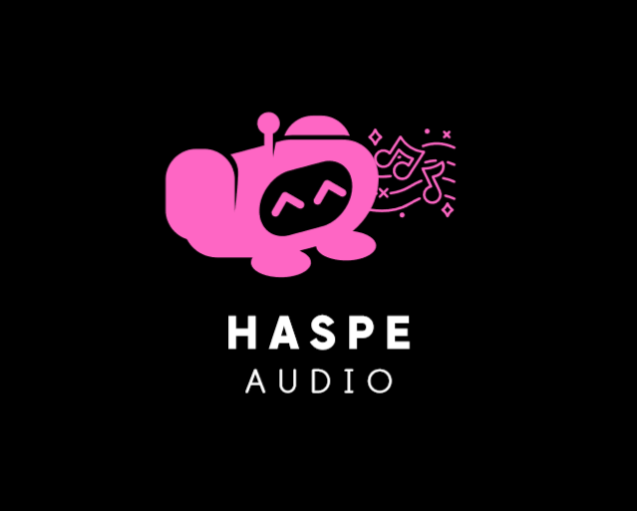

# **Installing and Importing Libraries**

In [1]:
!pip install python-telegram-bot
!pip install nest_asyncio
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install transformers
!pip install google-cloud-speech
!apt install python3.10-venv
!python -m venv speech_to_text_demo
!source speech_to_text_demo/bin/activate
!pip install pytchat
!pip install joblib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10-venv is already the newest version (3.10.12-1~22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import nest_asyncio
nest_asyncio.apply()

from typing import Final
import telegram
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from google.cloud import speech_v1
from IPython.display import display, Audio
import pytchat
import time
import torch
import joblib
import moviepy.editor as mp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing the Saved Model and Definining Functions**

In [4]:
# Haspe Audio Bot Constants
TOKEN: Final = 'Telegram Bot Token API'
BOT_USERNAME: Final = 'Telegram Bot Token Username'

# Set Google Cloud Speech-to-Text API credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Speech Recognition/credentials.json"

In [5]:
# Function to convert audio to text using Google Speech-to-Text
def convert_audio_to_text(audio_content):
    client = speech_v1.SpeechClient()

    # Configure audio recognition settings
    config = speech_v1.RecognitionConfig(
        encoding=speech_v1.RecognitionConfig.AudioEncoding.MP3,
        sample_rate_hertz=44100,
        language_code="en-US",
        model="video",
    )

    audio = speech_v1.RecognitionAudio(content=audio_content)

    # Recognize speech
    response = client.recognize(config=config, audio=audio)

    # Extract the transcriptions
    transcriptions = [result.alternatives[0].transcript for result in response.results]

    # Concatenate transcriptions into a single text
    text = ' '.join(transcriptions)

    return text

def load_model_and_predict(text):
    # Load the BERT model and tokenizer
    model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
    loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
    loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

    # Load the TensorFlow model
    tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'

    # Load the label encoder
    label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
    loaded_label_encoder = joblib.load(label_encoder_filename)


    # Tokenize and preprocess the input text
    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    return predicted_label

# **Code for Bot 2 - Haspe Audio**

In [6]:
# Command handlers
async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Hello! Thanks for chatting with me! I am the Haspe Audio Bot.')

async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('I am the Haspe Audio Bot! Please Record Audio using microhone so I can predict if it contains hate speech.')

async def audio_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Please Record Audio using Microphone!.')

async def handle_audio(update: Update, context: ContextTypes.DEFAULT_TYPE):
    # Get the uploaded audio file
    audio_file = await context.bot.getFile(update.message.voice.file_id)
    audio_content = await audio_file.download_as_bytearray()
    await update.message.reply_text('Processing your Audio. Please wait...')

    # Convert bytearray to bytes
    audio_bytes = bytes(audio_content)

    # Convert audio to text
    audio_text = convert_audio_to_text(audio_bytes)

    # Predict hate speech
    predicted_label = load_model_and_predict(audio_text)

    # Map the predicted label to the desired output
    if predicted_label == 'yes':
        predicted_output = 'Hate'
    else:
        predicted_output = 'Non-Hate'

    # Send prediction back to user
    await update.message.reply_text(f'Text Extracted from Audio: "{audio_text}"\nHate Speech Prediction for Audio: {predicted_output}')

async def handle_non_audio(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('The given input is not in audio format. Please enter Audio as Input.')

# Error handler
async def error(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f'Update {update} caused error {context.error}')

In [ ]:
if __name__ == '__main__':
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler('start', start_command))
    app.add_handler(CommandHandler('help', help_command))
    app.add_handler(CommandHandler('audio', audio_command))
    app.add_handler(MessageHandler(filters.VOICE, handle_audio))
    app.add_handler(MessageHandler(~filters.VOICE, handle_non_audio))  # This handler will catch non-audio inputs

    # Errors
    app.add_error_handler(error)

    # Polls the Bot
    print('Polling...')
    app.run_polling(poll_interval=3)

Polling...


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Hate Speech Detection Project/Project Execution/Backend Development/Hate Speech Detection Models/Mark 12/Saved Model 1/Hate Speech Hinglish Language/hate_speech_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



1/1 [==============================] - 8s 8s/step
